# **Object Proposal**

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn

In [2]:
df = pd.read_csv("../Dataset/train_small.csv", header=None)
df.columns = ["Image", "Label"]
df.head()

Image  Label
0             Image  Label
1  train_059371.jpg      0
2  train_059389.jpg      0
3  train_059425.jpg      0
4  train_059445.jpg      0

In [3]:
# Load Pre-trained Faster R-CNN
model = fasterrcnn_mobilenet_v3_large_320_fpn(
    weights="FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1"
)
model.eval()
rpn = model.rpn
transform = model.transform  # Get the model's transform

In [4]:
def apply_rpn(image_path, ax):
    # Load image using PIL
    image = Image.open(image_path).convert("RGB")

    # Convert to PyTorch tensor
    img_tensor = F.to_tensor(image).unsqueeze(0)  # Add batch dimension

    # Apply the model's transform to get proper ImageList
    with torch.no_grad():
        transformed_image_list = transform(img_tensor)[
            0
        ]  # Get the transformed ImageList
        features = model.backbone(transformed_image_list.tensors)

        # Apply RPN to get proposals
        proposals, _ = rpn(transformed_image_list, features)

    # Convert proposals to numpy and select top 50 proposals
    proposals = proposals[0].cpu().numpy()[:5]

    # Draw proposals on the image using PIL
    draw = ImageDraw.Draw(image)
    for x1, y1, x2, y2 in proposals:
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

    # Show image with proposals using Matplotlib
    ax.imshow(image)
    ax.axis("off")

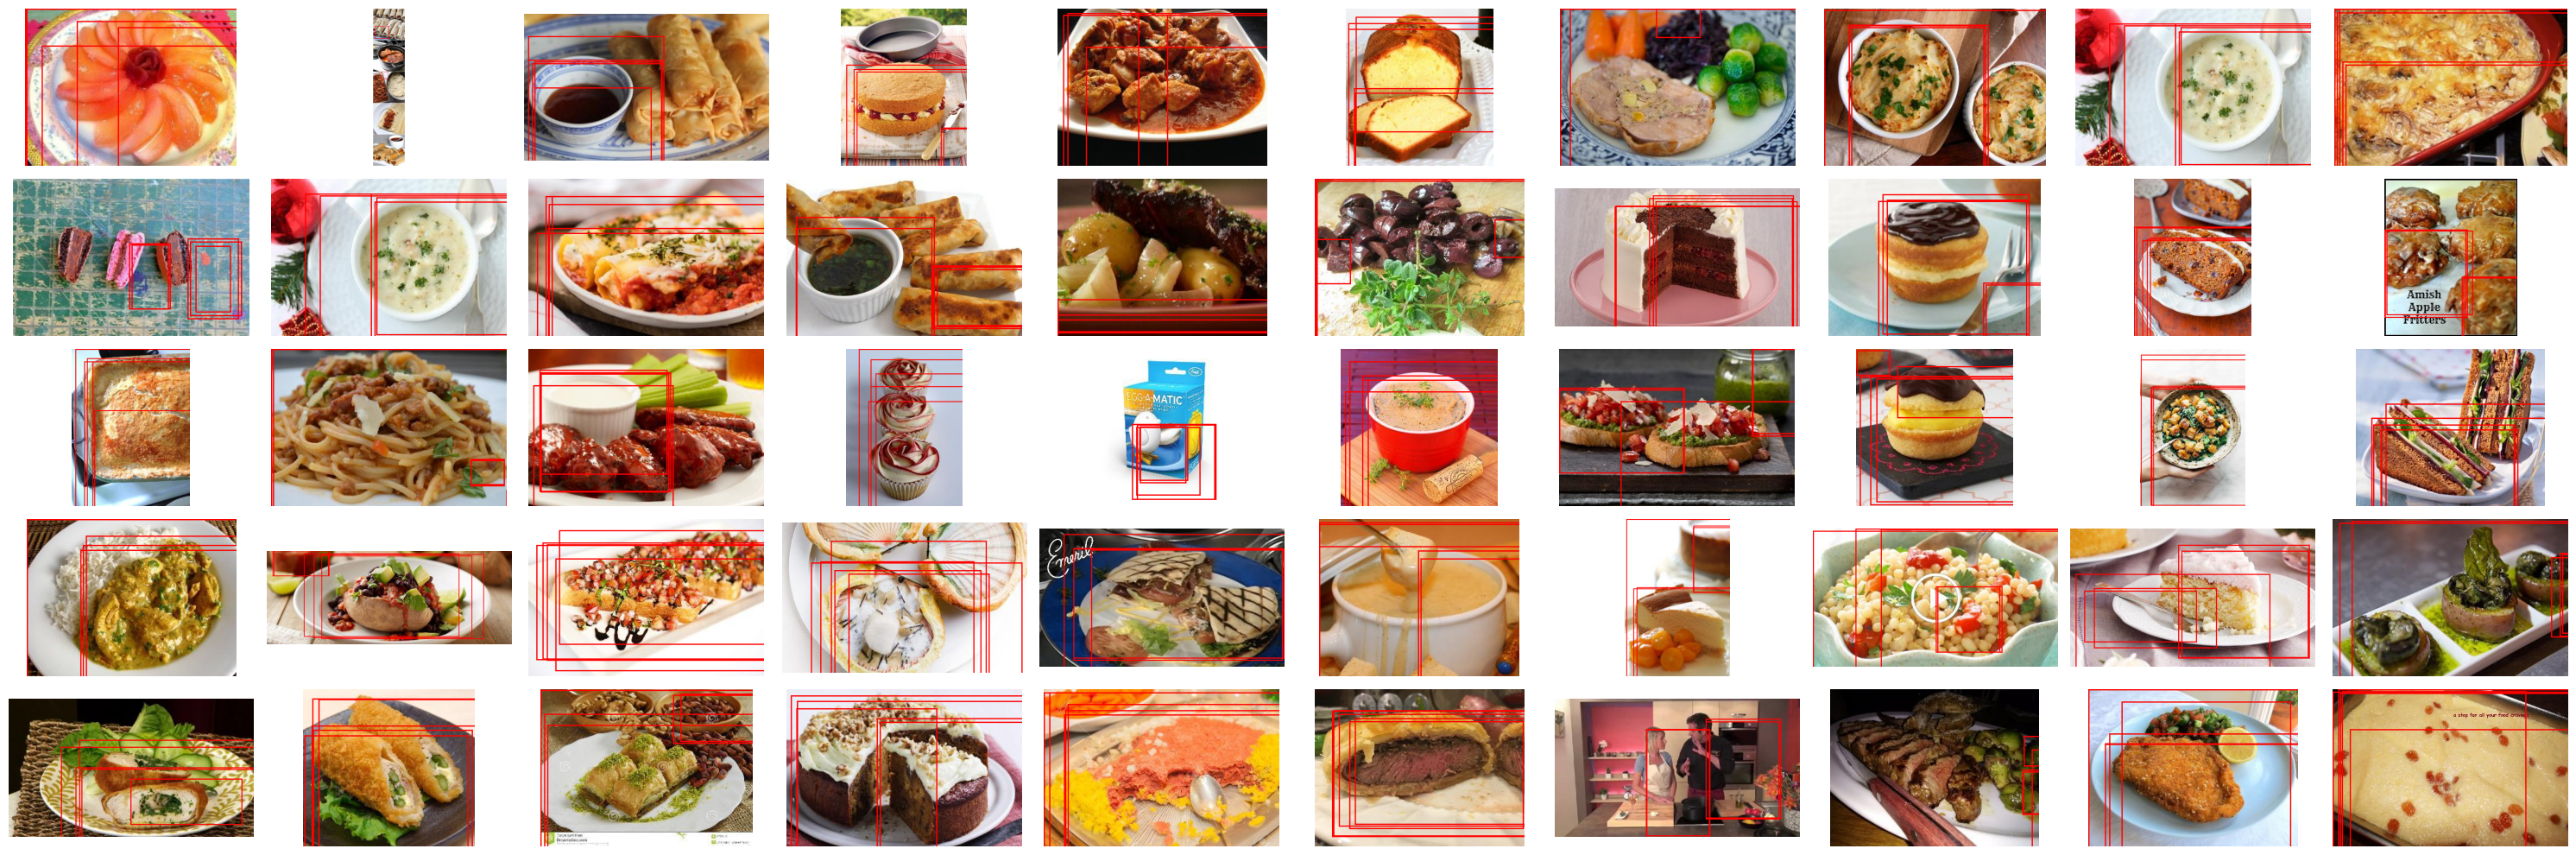

In [10]:
imgs = np.random.choice(df.Image, size=50)

fig, axs = plt.subplots(5, 10, figsize=(30, 10))
for i, img in enumerate(imgs):
  row = i // 10
  col = i % 10 
  apply_rpn(f"../Dataset/train_small/{img}", axs[row, col])

plt.tight_layout()
plt.show()

In [8]:
def apply_soft_attention(image_path, model, transform, rpn):
    # Load and transform image
    image = Image.open(image_path).convert("RGB")
    img_tensor = F.to_tensor(image).unsqueeze(0)
    
    with torch.no_grad():
        transformed_image_list = transform(img_tensor)[0]
        features = model.backbone(transformed_image_list.tensors)
        
        # Get proposals and scores
        proposals, proposal_losses = rpn(transformed_image_list, features)
        
        # Create attention mask
        attention_mask = torch.zeros_like(img_tensor)
        proposals = proposals[0]
        
        # Use top-k proposals (without scores since they're not directly accessible)
        k = min(10, len(proposals))  # Number of proposals to consider
        for box in proposals[:k]:
            x1, y1, x2, y2 = box.int()
            # Ensure indices are within image bounds
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(attention_mask.shape[3], x2)
            y2 = min(attention_mask.shape[2], y2)
            attention_mask[:, :, y1:y2, x1:x2] += 1.0
            
        # Normalize attention mask
        max_val = attention_mask.max()
        if max_val > 0:
            attention_mask = attention_mask / max_val
        
        # Apply attention to original image
        attended_image = img_tensor * attention_mask

    return attended_image

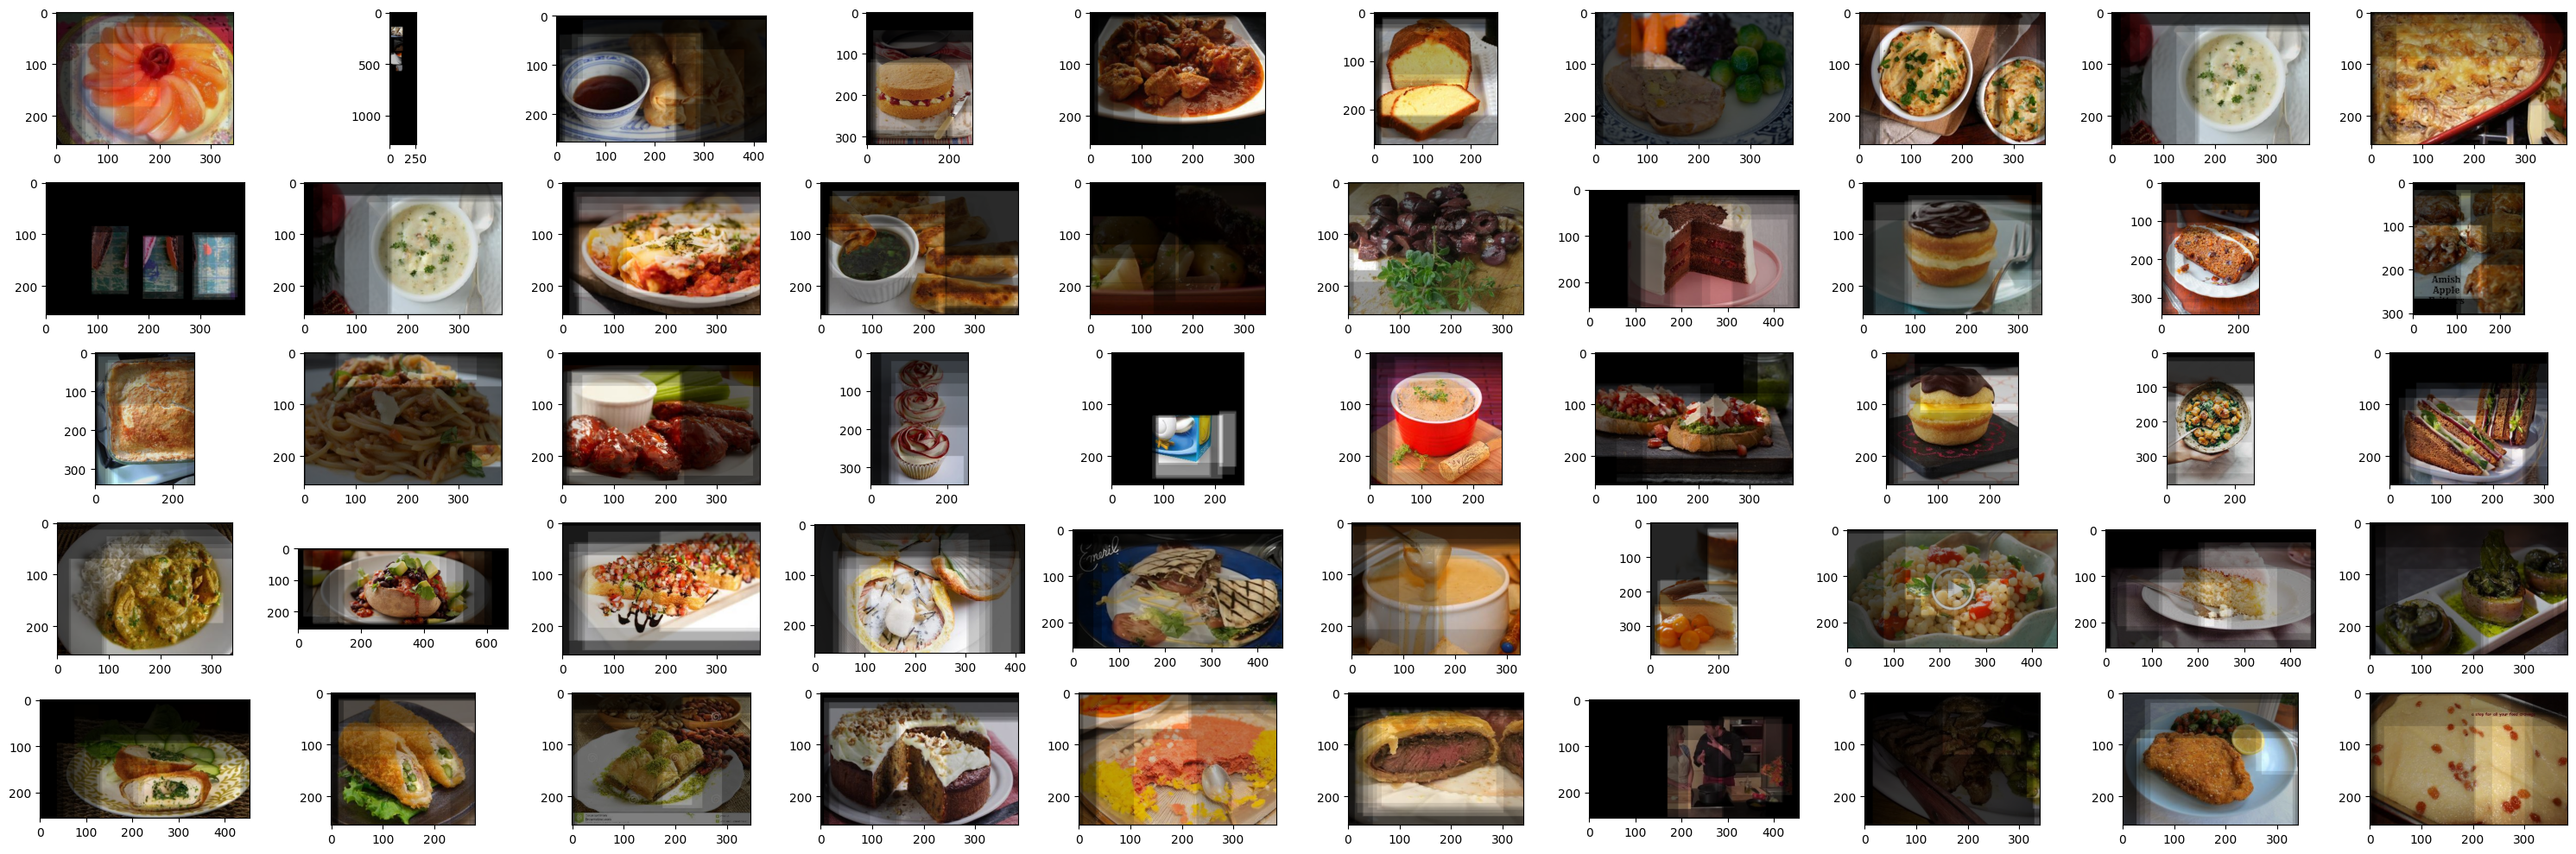

In [11]:
fig, axs = plt.subplots(5, 10, figsize=(30, 10))
for i, img in enumerate(imgs):
  row = i // 10
  col = i % 10 
  attended_image = apply_soft_attention(f"../Dataset/train_small/{img}", model, transform, rpn)
  axs[row, col].imshow(attended_image[0].permute(1, 2, 0).numpy())

plt.tight_layout()
plt.show()

My goal for using object proposal is to capture better features for food image classification. In particular, my idea is to use a region proposal network to identify the object and put to zero all the pixels outside the bounding box. Would you recommend this approach?


This is an interesting approach, but I have some concerns and alternative suggestions:

Potential Issues with Your Approach:
Zeroing out pixels outside the bounding box might be too aggressive and could lose important contextual information
Food items often have complex shapes and multiple components that might not be well-captured by a single bounding box
The RPN might not always perfectly locate the food item, especially if it wasn't specifically trained on food data
Alternative Suggestions: a) Soft Attention Masking: Instead of binary masking (zeroing out), you could use the proposal confidence to create a soft attention mechanism that weighs the features. This would preserve some context while emphasizing the main object. b) Multiple RoI Pooling: Consider using multiple top-k proposals and pooling features from each region, then combining them (through concatenation or attention mechanisms) for final classification. c) Food-Specific Region Proposal: If possible, fine-tune the RPN on food data to get better proposals for your specific use case.